# CARGADO DE LIBRERIAS

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time
import cv2
import shutil
import random

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.16.2


In [55]:
# habilitado de precision mixta de entrenaimiento, reduce el uso de memoria
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision enabled')

Mixed precision enabled


# ANALISIS EXPLORATORIO DE DATOS

In [15]:
# Dividimos el dataset en entrenamiento, validacion y test
def split_images(main_folder, output_folders, percentages):
    # Crear carpetas de salida y replicar la estructura de subcarpetas
    for folder in output_folders:
        os.makedirs(folder, exist_ok=True)
        for subfolder in os.listdir(main_folder):
            subfolder_path = os.path.join(main_folder, subfolder)
            if os.path.isdir(subfolder_path):
                os.makedirs(os.path.join(folder, subfolder), exist_ok=True)

    # Procesar cada subcarpeta
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path):
            images = [img for img in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, img))]
            random.shuffle(images)

            total_images = len(images)
            start = 0
            for folder, percent in zip(output_folders, percentages):
                count = int(total_images * percent)
                selected_images = images[start:start+count]
                start += count

                for img in selected_images:
                    src = os.path.join(subfolder_path, img)
                    dst = os.path.join(folder, subfolder, img)
                    shutil.copy2(src, dst)

# Define las rutas y porcentajes
main_folder = './DATSET_BIG_20'
output_folders = ['train', 'val', 'test']
percentages = [0.72, 0.14, 0.14]

# Ejecuta la función
split_images(main_folder, output_folders, percentages)
print("Las imágenes se han distribuido correctamente.")

Las imágenes se han distribuido correctamente.


In [57]:
dataset_dir = './train'

In [59]:
CLASS_NAMES = [nombre for nombre in os.listdir(dataset_dir)
               if os.path.isdir(os.path.join(dataset_dir, nombre))]
CLASS_NAMES = sorted(CLASS_NAMES)
CLASS_NAMES

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'NOTHING',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'SPACE',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [61]:
def create_dataset_from_directory(data_dir):
    """Create dataset from directory structure"""
    image_paths = []
    labels = []

    # Walk through directory structure
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            class_label = CLASS_NAMES.index(class_name)

            for image_file in os.listdir(class_dir):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_dir, image_file)
                    image_paths.append(image_path)
                    labels.append(class_label)

    return image_paths, labels

In [63]:
image_paths, labels = create_dataset_from_directory(dataset_dir)

In [65]:
label_counts = Counter(labels)
print("Distribucion de clases")

for i, count in sorted(label_counts.items()):
  print(f"{CLASS_NAMES[i]}: {count} imagenes")

Distribucion de clases
A: 1211 imagenes
B: 1185 imagenes
C: 1197 imagenes
D: 1152 imagenes
E: 1127 imagenes
F: 1188 imagenes
G: 1166 imagenes
H: 1162 imagenes
I: 1182 imagenes
J: 1057 imagenes
K: 1174 imagenes
L: 1190 imagenes
M: 1175 imagenes
N: 1186 imagenes
NOTHING: 603 imagenes
O: 1203 imagenes
P: 1154 imagenes
Q: 1203 imagenes
R: 1206 imagenes
S: 1206 imagenes
SPACE: 996 imagenes
T: 1186 imagenes
U: 1071 imagenes
V: 1141 imagenes
W: 1173 imagenes
X: 1202 imagenes
Y: 1198 imagenes
Z: 1048 imagenes


In [67]:
label_counts

Counter({0: 1211,
         18: 1206,
         19: 1206,
         15: 1203,
         17: 1203,
         25: 1202,
         26: 1198,
         2: 1197,
         11: 1190,
         5: 1188,
         13: 1186,
         21: 1186,
         1: 1185,
         8: 1182,
         12: 1175,
         10: 1174,
         24: 1173,
         6: 1166,
         7: 1162,
         16: 1154,
         3: 1152,
         23: 1141,
         4: 1127,
         22: 1071,
         9: 1057,
         27: 1048,
         20: 996,
         14: 603})

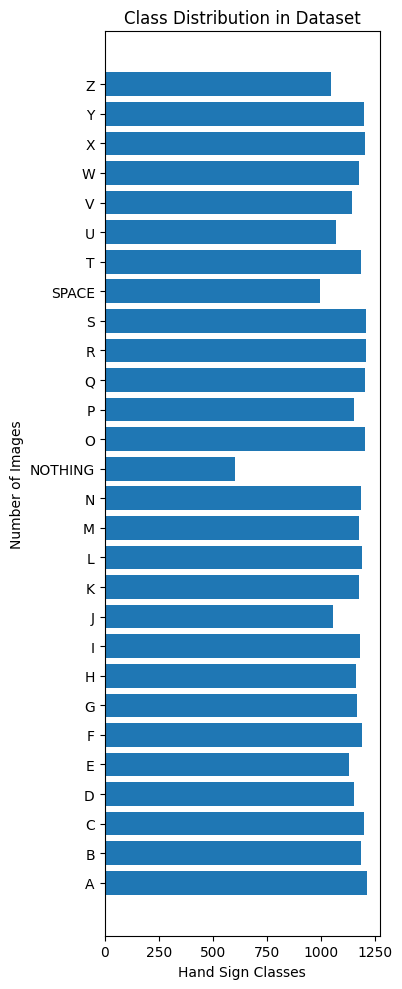

In [69]:
# Visualizacion de la distribucion de imagenes en cada signo del lenguaje 
plt.figure(figsize=(4, 10))
class_names_sorted = [CLASS_NAMES[i] for i in sorted(label_counts.keys())]
counts_sorted = [label_counts[i] for i in sorted(label_counts.keys())]

plt.barh(class_names_sorted, counts_sorted)
plt.title('Class Distribution in Dataset')
plt.xlabel('Hand Sign Classes')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [71]:
def display_sample_images(image_paths, labels, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 40))

    for class_idx, class_name in enumerate(class_names):
        # Find images for this class
        class_images = [path for path, label in zip(image_paths, labels) if label == class_idx]

        for sample_idx in range(min(num_samples, len(class_images))):
            if len(class_names) > 1:
                ax = axes[class_idx, sample_idx]
            else:
                ax = axes[sample_idx]

            img = cv2.imread(class_images[sample_idx])
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
                ax.set_title(f'{class_name} - Sample {sample_idx + 1}')
            else:
                ax.text(0.5, 0.5, f'Error loading\nimage',
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{class_name} - Load Error')
            ax.axis('off')

        for sample_idx in range(len(class_images), num_samples):
            if len(class_names) > 1:
                ax = axes[class_idx, sample_idx]
            else:
                ax = axes[sample_idx]
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [73]:
def sample_balanced_images(image_paths, labels, class_names, num_samples=3):
    sampled_paths = []
    sampled_labels = []

    for class_idx, class_name in enumerate(class_names):
        class_images = [(path, label) for path, label in zip(image_paths, labels) if label == class_idx]

        if len(class_images) == 0:
            continue

        selected = class_images[:num_samples]
        for path, label in selected:
            sampled_paths.append(path)
            sampled_labels.append(label)

    return sampled_paths, sampled_labels

Imagenes de muestra de las primeras 10 clases...


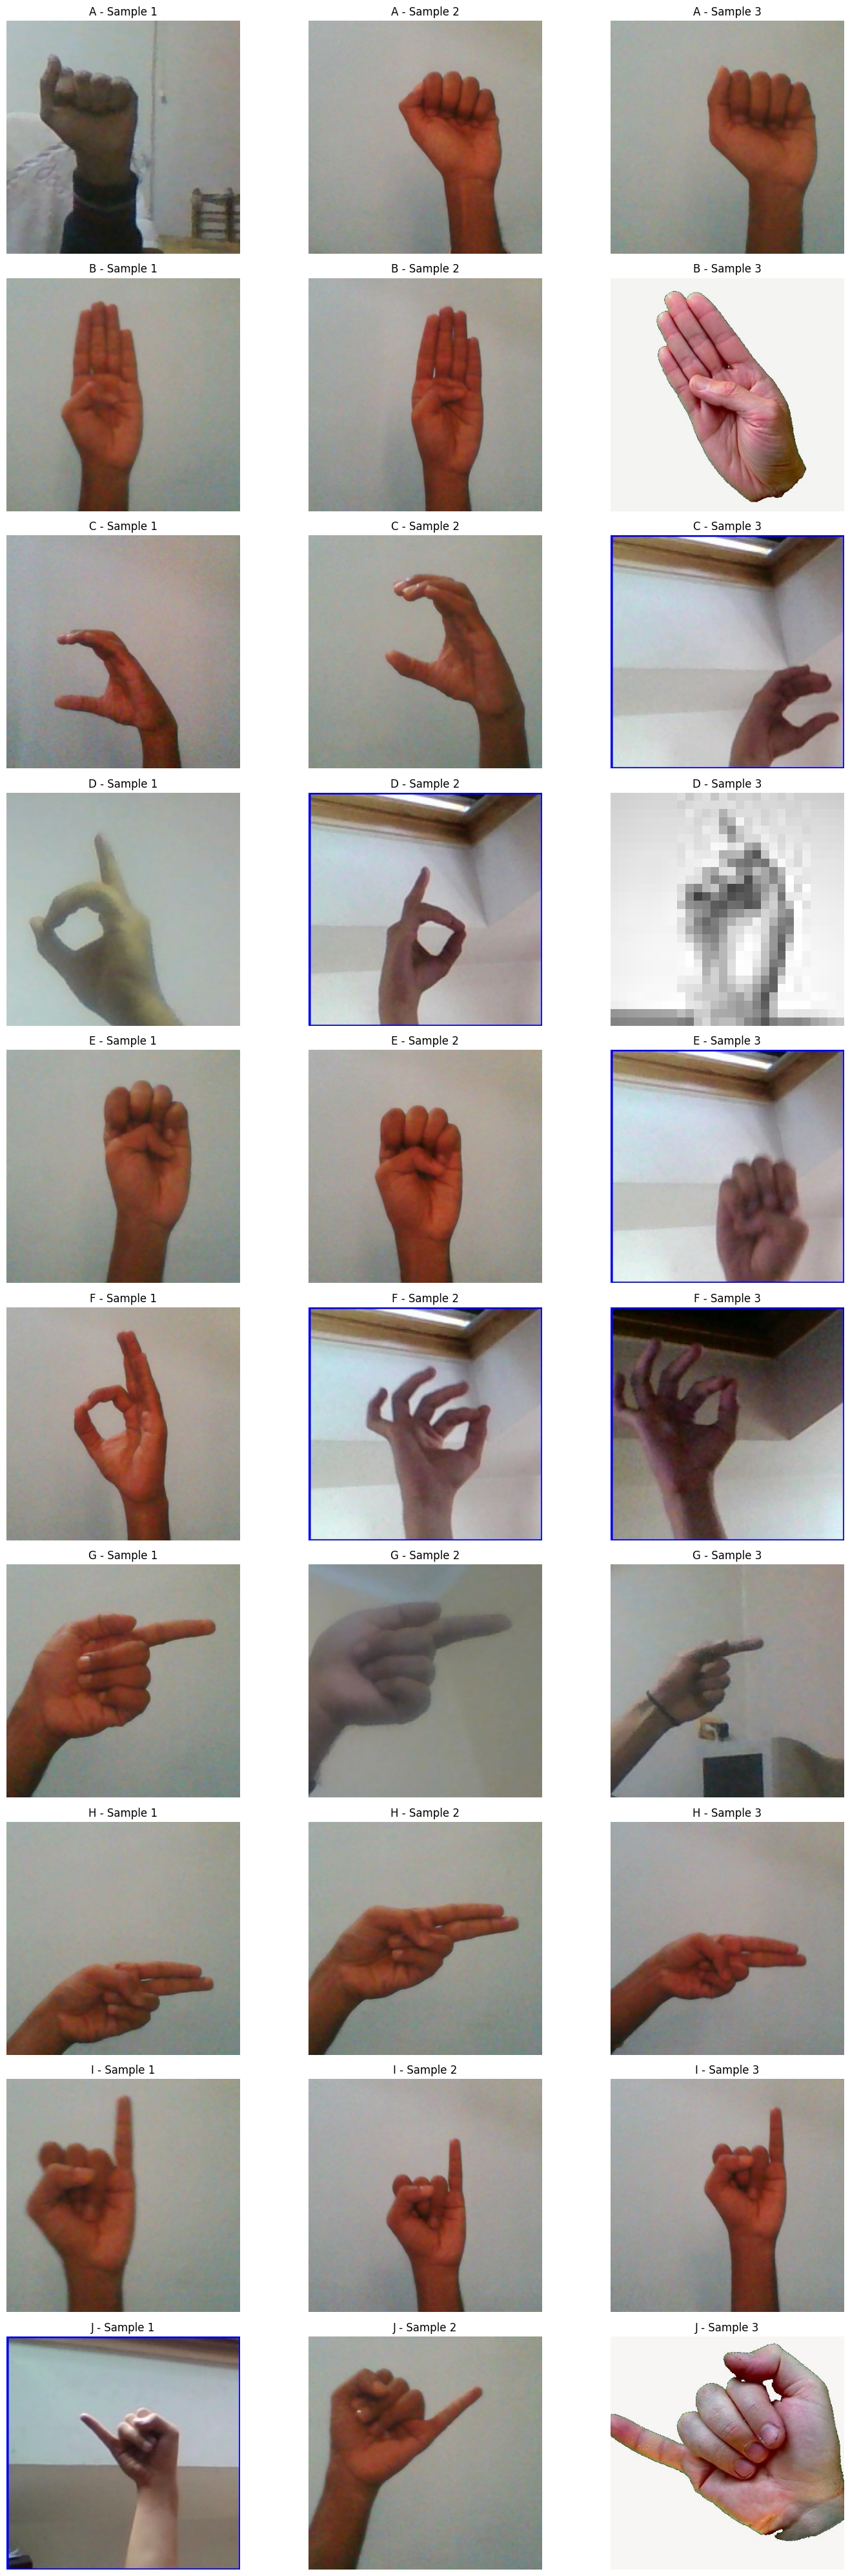

In [75]:
balanced_image_paths, balanced_labels = sample_balanced_images(image_paths, labels, CLASS_NAMES[:10], num_samples=3)

print("Imagenes de muestra de las primeras 10 clases...")
display_sample_images(balanced_image_paths, balanced_labels, CLASS_NAMES[:10], num_samples=3)

# Preprocesamiento de imagenes y definicion de los sets train, val, test

In [78]:
# Image size and batch size
BATCH_SIZE = 128
IMG_HEIGHT = 160
IMG_WIDTH = 160

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./train",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 31942 files belonging to 28 classes.


In [80]:
# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "./val",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 6378 files belonging to 28 classes.


In [82]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "./test",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 6378 files belonging to 28 classes.


In [84]:
# Get the class names from the dataset
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found the following classes:")
print(class_names)
print(f"Total number of classes: {num_classes}")

# --- MobileNetV2 preprocessing ---
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found the following classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NOTHING', 'O', 'P', 'Q', 'R', 'S', 'SPACE', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total number of classes: 28


# Division del set en 5fold-CV (Fallido)

In [41]:
# Preparar train_dataset para k-fold
# X = []
# y = []
# for images, labels in train_dataset:
#     X.append(images.numpy())
#     y.append(labels.numpy())

# X = np.concatenate(X)
# y = np.concatenate(y)

# num_classes = len(np.unique(y))

# def create_model(num_classes):
#     base_model = tf.keras.applications.MobileNetV2(
#         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#         include_top=False,
#         weights='imagenet'
#     )
#     base_model.trainable = False
#     inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#     x = layers.RandomRotation(0.2)(inputs)
#     x = base_model(x, training=False)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.2)(x)
#     outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
#     model = tf.keras.Model(inputs, outputs)
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#         metrics=['accuracy']
#     )
#     return model

# IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# def create_model(num_classes):
#     # Load the base model without the top classification layer
#     base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')

#     # Freeze the convolutional base to prevent its weights from being updated
#     # during the initial training phase.
#     base_model.trainable = False

#     # Create a new model on top
#     inputs = tf.keras.Input(shape=IMG_SHAPE)
    
#     # Data augmentation layer
#     data_augmentation = keras.Sequential([
#         layers.RandomRotation(0.2),
#     ])
    
#     x = data_augmentation(inputs)
#     x = base_model(x, training=False) # Run the base model in inference mode
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.2)(x)

#     # The final prediction layer needs to be float32 for numerical stability with mixed precision
#     outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
#     model = tf.keras.Model(inputs, outputs)

#     # Compile the model
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   metrics=['accuracy'])

#     return model

# NUM_FOLDS=5
# kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
# fold_no = 1
# accuracy_per_fold = []
# loss_per_fold = []
# initial_epochs = 5

# for train_index, val_index in kf.split(X):
#     print(f"\n--- Fold {fold_no} ---")
#     x_train, x_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     model = create_model(num_classes)

#     history = model.fit(
#         x_train, y_train,
#         epochs=initial_epochs,
#         validation_data=(x_val, y_val),
#         verbose=1
#     )

#     scores = model.evaluate(x_val, y_val, verbose=0)
#     print(f"Fold {fold_no} - Loss: {scores[0]:.4f} - Accuracy: {scores[1]:.4f}")
#     accuracy_per_fold.append(scores[1])
#     loss_per_fold.append(scores[0])
#     fold_no += 1


# print("\n--- Resultados de Validación Cruzada ---")
# print(f"Precisión promedio: {np.mean(accuracy_per_fold):.4f}")
# print(f"Pérdida promedio: {np.mean(loss_per_fold):.4f}")

In [47]:
# resultado del k-fold 5


--- Fold 1 ---
Epoch 1/5


2025-08-10 08:30:34.631305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


799/799 ━━━━━━━━━━━━━━━━━━━━ 111s 134ms/step - accuracy: 0.0378 - loss: 3.4427 - val_accuracy: 0.0255 - val_loss: 3.8675
Epoch 2/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - accuracy: 0.0336 - loss: 3.4156 - val_accuracy: 0.0252 - val_loss: 3.8871
Epoch 3/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 95s 118ms/step - accuracy: 0.0356 - loss: 3.4115 - val_accuracy: 0.0316 - val_loss: 3.8552
Epoch 4/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 98s 123ms/step - accuracy: 0.0357 - loss: 3.3978 - val_accuracy: 0.0252 - val_loss: 3.8545
Epoch 5/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 100s 125ms/step - accuracy: 0.0364 - loss: 3.3976 - val_accuracy: 0.0225 - val_loss: 3.8915
Fold 1 - Loss: 3.8915 - Accuracy: 0.0225

--- Fold 2 ---
Epoch 1/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 116s 140ms/step - accuracy: 0.0375 - loss: 3.4836 - val_accuracy: 0.0362 - val_loss: 4.0748
Epoch 2/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - accuracy: 0.0342 - loss: 3.4132 - val_accuracy: 0.0344 - val_loss: 4.1039
Epoch 3/5
799/799 ━━━━━━━━━━━━━━━━━━━━ 1

KeyboardInterrupt: 

# Arquitectura de la Red Neuronal

In [86]:
# Load the base model without the top classification layer
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# Mostrar todas las capas con su índice y estado de entrenamiento
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d}: {layer.name:40s} | Trainable: {layer.trainable}")


  0: input_layer_1                            | Trainable: True
  1: Conv1                                    | Trainable: True
  2: bn_Conv1                                 | Trainable: True
  3: Conv1_relu                               | Trainable: True
  4: expanded_conv_depthwise                  | Trainable: True
  5: expanded_conv_depthwise_BN               | Trainable: True
  6: expanded_conv_depthwise_relu             | Trainable: True
  7: expanded_conv_project                    | Trainable: True
  8: expanded_conv_project_BN                 | Trainable: True
  9: block_1_expand                           | Trainable: True
 10: block_1_expand_BN                        | Trainable: True
 11: block_1_expand_relu                      | Trainable: True
 12: block_1_pad                              | Trainable: True
 13: block_1_depthwise                        | Trainable: True
 14: block_1_depthwise_BN                     | Trainable: True
 15: block_1_depthwise_relu             

## Estructura para fase inicial de entrenamiento

In [90]:
# Congela el modelo base, para no actualizar los pesos
base_model.trainable = False

# Indica el tipo de entradas que tendra la capa inicial
inputs = tf.keras.Input(shape=IMG_SHAPE)
# Capa de aumento de ejemplos, indica que se tendra una rotación de 20% para mejorar la generalizacion
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),
])
x = data_augmentation(inputs)
x = base_model(x, training=False) # se ejecutara en modo inferencia

# define las capas nuevas que seran agregadas al modelo
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,852 (8.75 MB)

 Trainable params: 35,868 (140.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento Inicial

In [93]:
print("\n--- Starting Initial Training (Classifier Head) ---")
start_time = time.time()
initial_epochs = 5

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)
initial_training_time = time.time() - start_time
print(f"Initial training took: {initial_training_time:.2f} seconds")


--- Starting Initial Training (Classifier Head) ---
Epoch 1/5


2025-08-10 15:17:55.341822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 326ms/step - accuracy: 0.1053 - loss: 3.4324 - val_accuracy: 0.4763 - val_loss: 2.1350
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 318ms/step - accuracy: 0.3867 - loss: 2.2478 - val_accuracy: 0.6181 - val_loss: 1.5807
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 347ms/step - accuracy: 0.5170 - loss: 1.8000 - val_accuracy: 0.6717 - val_loss: 1.3172
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 367ms/step - accuracy: 0.5857 - loss: 1.5520 - val_accuracy: 0.7057 - val_loss: 1.1600
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 332ms/step - accuracy: 0.6259 - loss: 1.3884 - val_accuracy: 0.7261 - val_loss: 1.0553
Initial training took: 426.13 seconds


## Ajuste fino

In [97]:
# descongelamos las capas de MobileNetV2
base_model.trainable = True

# indicamos las capas que se descongelaran
fine_tune_at = 70

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compilamos el modelo con learning rate bajo para no afectar demasiado
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,852 (8.75 MB)

 Trainable params: 2,129,052 (8.12 MB)

 Non-trainable params: 164,800 (643.75 KB)

## Definicion de Callbacks y re-entrenamiento

In [100]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)

print("\n--- Starting Fine-Tuning ---")
start_time = time.time()
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    callbacks=[early_stopping, lr_scheduler]
)
fine_tuning_time = time.time() - start_time
print(f"Fine-tuning took: {fine_tuning_time:.2f} seconds")


--- Starting Fine-Tuning ---
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 626ms/step - accuracy: 0.4767 - loss: 1.8911 - val_accuracy: 0.7676 - val_loss: 0.8254 - learning_rate: 1.0000e-05
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 718ms/step - accuracy: 0.6895 - loss: 1.1142 - val_accuracy: 0.8043 - val_loss: 0.6976 - learning_rate: 1.0000e-05
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 620ms/step - accuracy: 0.7645 - loss: 0.8184 - val_accuracy: 0.8346 - val_loss: 0.5852 - learning_rate: 1.0000e-05
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 628ms/step - accuracy: 0.8118 - loss: 0.6410 - val_accuracy: 0.8628 - val_loss: 0.4894 - learning_rate: 1.0000e-05
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 641ms/step - accuracy: 0.8441 - loss: 0.5316 - val_accuracy: 0.8812 - val_loss: 0.4217 - learning_rate: 1.0000e-05
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 157s 628ms/step - accuracy: 0.8660 - loss: 0.4489 - val_accuracy: 0.8965 - val_loss: 0.3614 - learning_rate: 1.0000e-05
Epoch 11/

# Evaluacion

In [104]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

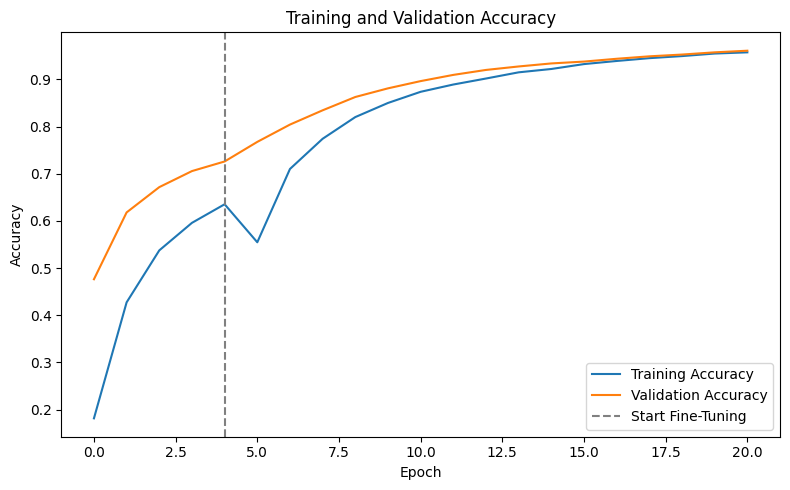

In [106]:
plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

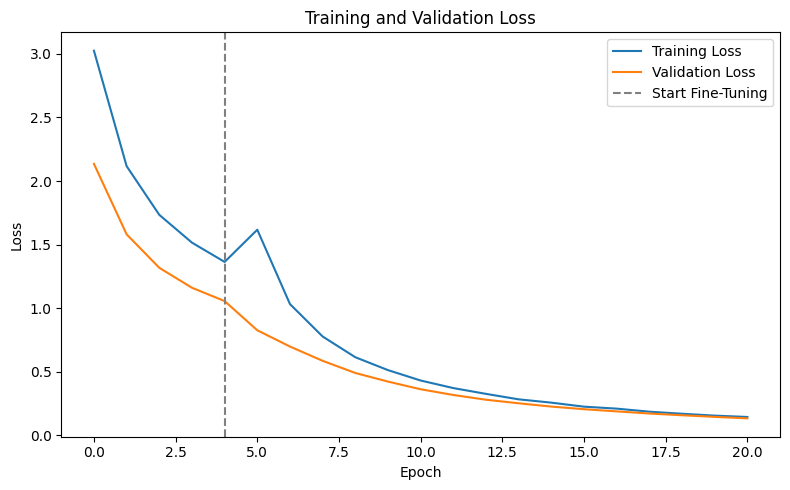

In [108]:
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


--- FINAL EVALUATION ON TEST SET ---
TEST loss: 0.1375 | TEST accuracy: 0.9595
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step


2025-08-10 18:56:53.046543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



TEST Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.96      0.96       242
           B       1.00      0.99      1.00       237
           C       0.98      1.00      0.99       239
           D       0.97      0.98      0.97       230
           E       0.96      0.99      0.97       225
           F       0.98      0.99      0.98       237
           G       0.94      0.98      0.96       233
           H       0.96      0.95      0.95       232
           I       0.96      0.93      0.94       236
           J       0.95      0.96      0.96       211
           K       0.94      0.96      0.95       234
           L       0.99      0.97      0.98       238
           M       0.98      0.89      0.93       235
           N       0.90      0.97      0.93       237
     NOTHING       1.00      0.99      1.00       120
           O       0.98      0.98      0.98       240
           P       0.98      0.98      0.98       23

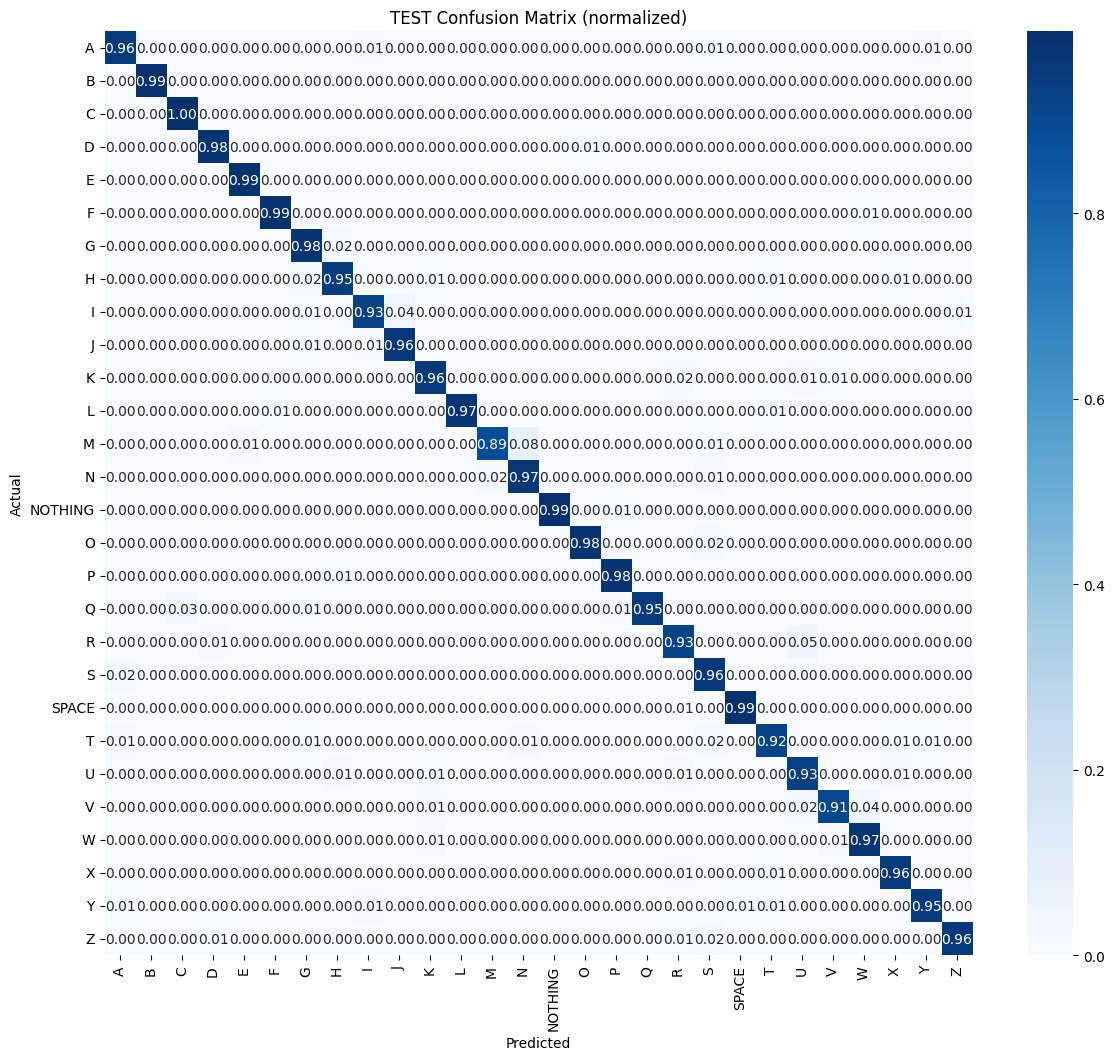

In [110]:
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

print("\n--- FINAL EVALUATION ON TEST SET ---")
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"TEST loss: {test_loss:.4f} | TEST accuracy: {test_acc:.4f}")

test_preds = model.predict(test_dataset)
test_pred_labels = np.argmax(test_preds, axis=1)
test_true_labels = np.concatenate([y for _, y in test_dataset], axis=0)

print("\nTEST Classification Report:")
print(classification_report(
    test_true_labels,
    test_pred_labels,
    labels=np.arange(num_classes),     # keep consistent class order
    target_names=class_names,
    zero_division=0
))


cm = confusion_matrix(test_true_labels, test_pred_labels)
cm_sum = cm.sum(axis=1)[:, np.newaxis]
cm_norm = np.divide(cm.astype('float'), cm_sum, out=np.zeros_like(cm, dtype=float), where=cm_sum!=0)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('TEST Confusion Matrix (normalized)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()